In [1]:
# ---- Includes ----

import re
import nltk
import spacy
import torch
import pickle
import optuna
import scikitplot
import matplotlib
import unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

nltk.download('punkt')              # Download to be able to use word_tokenize from nltk library

!pip install optuna                 # Download to be able to use Optuna as hyper-parameter
!python -m spacy download el        # Download to be able to lemmatize greek words using spacy
!pip install greek-stemmer-pos      # Download to be able to use stem on greek words
!pip install --upgrade scikit-learn # Download to be able to import roc_auc_score (new edition stuff)

from tabulate import tabulate
from wordcloud import WordCloud
from collections import Counter
from greek_stemmer import stemmer

from gensim.models import Word2Vec

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from torch.utils.data import TensorDataset, DataLoader

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
⚠ As of spaCy v3.0, shortcuts like 'el' are deprecated. Please use the
full pipeline package name 'el_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 60.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
  Obtaining dependency information for pytest-cov from https://files.pythonhosted.org/packages/a7/4b/8b78d126e275efa2379b1c2e09dc52cf70df16fc3b90613ef82531499d73/pytest_cov-4.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for coverage[toml]>=5.2.1 from https://files.pythonhosted.org/packages/94/1b/bd597a07755b233822760c9998d603218ca4b3151b6d5048e9fd0a5bf572/coverage-7.3.4-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.4/228.4 kB 6.1 MB/s eta 0:00

# Datasets

In [2]:
# ---- Reading the datasets ----

df_test = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/test_set.csv')
df_train = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/train_set.csv')
df_valid = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/valid_set.csv')

# Data pre-processing

In [3]:
# ---- NaN values ----

df_test.dropna(inplace = True)   # Good practice to
df_train.dropna(inplace = True)  # remove all empty   
df_valid.dropna(inplace = True)  # values of the datasets

In [4]:
# ---- Stopwords ----

nltk.download('stopwords')
nlp = spacy.load('el_core_news_sm')

spacy_greek_stopwords = nlp.Defaults.stop_words       # Greek stopwords from spacy
nltk_greek_stopwords = set(stopwords.words('greek'))  # Greek stopwords from nltk

english_stopwords = set(stopwords.words('english'))
greek_stopwords = spacy_greek_stopwords.union(nltk_greek_stopwords) # Combination of those so there is a bigger list of stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# ---- Cleansing / Tokenizing ----

mapping_names = {
    'αλεξη' : 'αλεξης',
    'τσιπρα' : 'τσιπρας',
    'συριζας' : 'συριζα',
    'κουλη' : 'κυριακος',
    'κουλης' : 'κυριακος',
    'κυριακο' : 'κυριακος',
    'μητσοτακη' : 'μητσοτακης',
}

def replace_words(text):
    words = text.split()                                                # If the word is inside the dictionary (map for names)
    replaced_words = [mapping_names.get(word, word) for word in words]  # change it. Lemmatizer can't convert those names and if 
    return ' '.join(replaced_words)                                     # there's no usage of lemmatizer names must be equal

def split_connected(text):
    english_letters = r'[A-Za-z]+'
    greek_letters = r'[Α-Ωα-ωίϊΐόάέύϋΰήώ]+'
    
    greek = re.findall(greek_letters, text)     # Go and find the greek and the english 
    english = re.findall(english_letters, text) # words based on the patern above
    
    return ' '.join(english + greek)  # End combine them to have cleaner text. For example "Greekεκλογες" will be "Greek εκλογες"

def remove_accent(text):
    normalized = unicodedata.normalize('NFD', text)                              # Using unicodedata to decompose characters
    new_text = [char for char in normalized if not unicodedata.combining(char)]  # with tones or any accent and be able to keep
    return ''.join(new_text)

def stem_text(text):
    words = text.split()                                               # Split the text into words
    stemmed_words = [stemmer.stem_word(word,'VBG') for word in words]  # stem every word of the text 
    return ' '.join(stemmed_words)                                     # and join all text pieces

def lemmatize_text(text):
    tokens = nlp(text)                                     # Tokenize the text
    lemmatized_words = [token.lemma_ for token in tokens]  # then apply lemmatization
    return ' '.join(lemmatized_words)                      # and join all the tokens

def text_cleaning(column):
    column = column.str.lower()                                # All to lowercase first
    column = column.str.replace(r'[@#]', '', regex = True)     # Remove all mentions and hashtags
    column = column.str.replace(r'www\S+', '', regex = True)   # Remove anything that 
    column = column.str.replace(r'http\S+', '', regex = True)  # has to do with links 
    column = column.str.replace(r'[^\w\s]', '', regex = True)  # Remove all punctuation marks
       
    column = column.apply(split_connected)
    
    column = column.apply(lambda x: ' '.join(x.split())) # Replace consecutive whitespaces so the resulting description will contain a single space between words
    column = column.apply(lambda x: re.sub(r'(.)\1{2,}', r'\1\1', x)) # Replace 3 or more same consecutive characters by 2 using regular expressions (e.g balll will become ball)
    column = column.apply(lambda x: ' '.join([word for word in x.split() if word not in greek_stopwords]))   # Remove greek stopwords
    column = column.apply(lambda x: ' '.join([word for word in x.split() if word not in english_stopwords])) # Remove english stopwords

#     column = column.apply(stem_text)
#     column = column.str.lower()
#     column = column.apply(lemmatize_text)
    column = column.apply(remove_accent)
    column = column.apply(replace_words)
    
    return column

df_test['Text'] = text_cleaning(df_test['Text'])
df_train['Text'] = text_cleaning(df_train['Text'])
df_valid['Text'] = text_cleaning(df_valid['Text'])

df_test['Tokens'] = df_test['Text'].apply(word_tokenize)
df_train['Tokens'] = df_train['Text'].apply(word_tokenize)
df_valid['Tokens'] = df_valid['Text'].apply(word_tokenize)

df_train['Sentiment_encoded'] = LabelEncoder().fit_transform(df_train['Sentiment'])
df_valid['Sentiment_encoded'] = LabelEncoder().fit_transform(df_valid['Sentiment'])

# Data Analysis

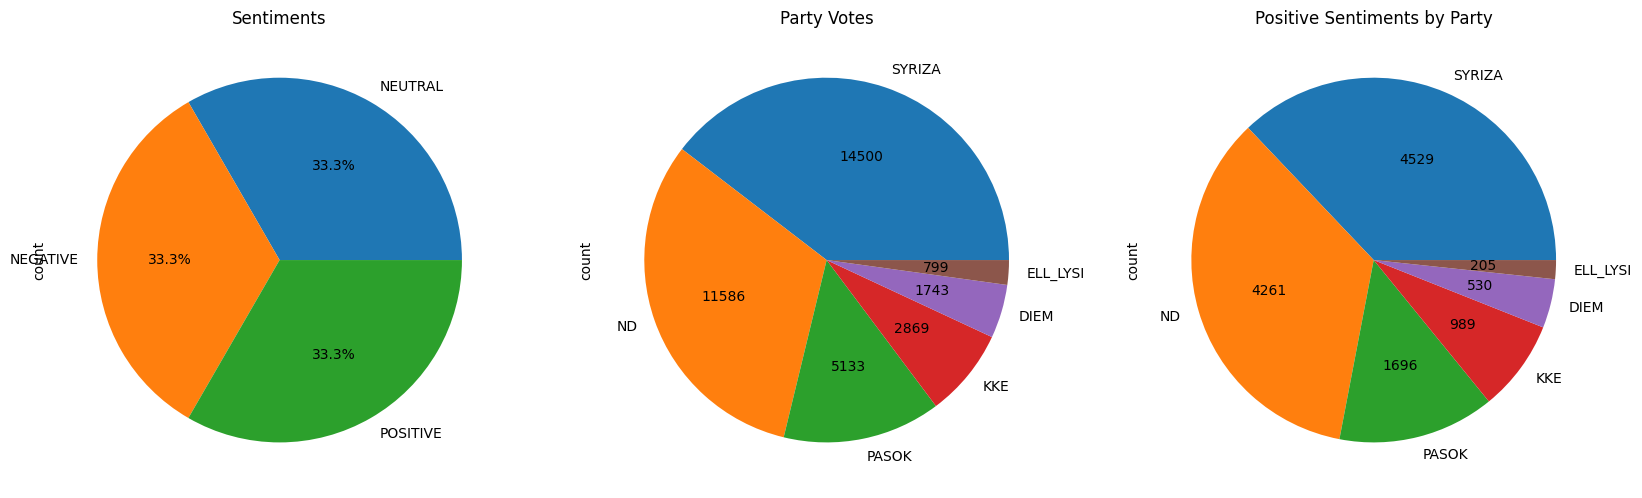

In [6]:
# ---- Pie Plots ----

plt.figure(figsize = (20, 8))

# What is the distribution of the sentiment
total_sentiment_distribution = df_train['Sentiment'].value_counts()

plt.subplot(1, 3, 1)
total_sentiment_distribution.plot(kind = 'pie', autopct = '%1.1f%%')
plt.title('Sentiments')

# Whats the total votes every party has
total_votes_party = df_train['Party'].value_counts()

plt.subplot(1, 3, 2)
total_votes_party.plot(kind = 'pie', autopct = lambda p: '{:.0f}'.format(p * total_votes_party.sum() / 100))
plt.title('Party Votes')

# How many positive sentiments each party has
positive_sentiment_party = df_train[df_train['Sentiment'] == 'POSITIVE']['Party'].value_counts()

plt.subplot(1, 3, 3)
positive_sentiment_party.plot(kind = 'pie', autopct = lambda p: '{:.0f}'.format(p * positive_sentiment_party.sum() / 100))
plt.title('Positive Sentiments by Party')

# Show all analysis #
plt.show()

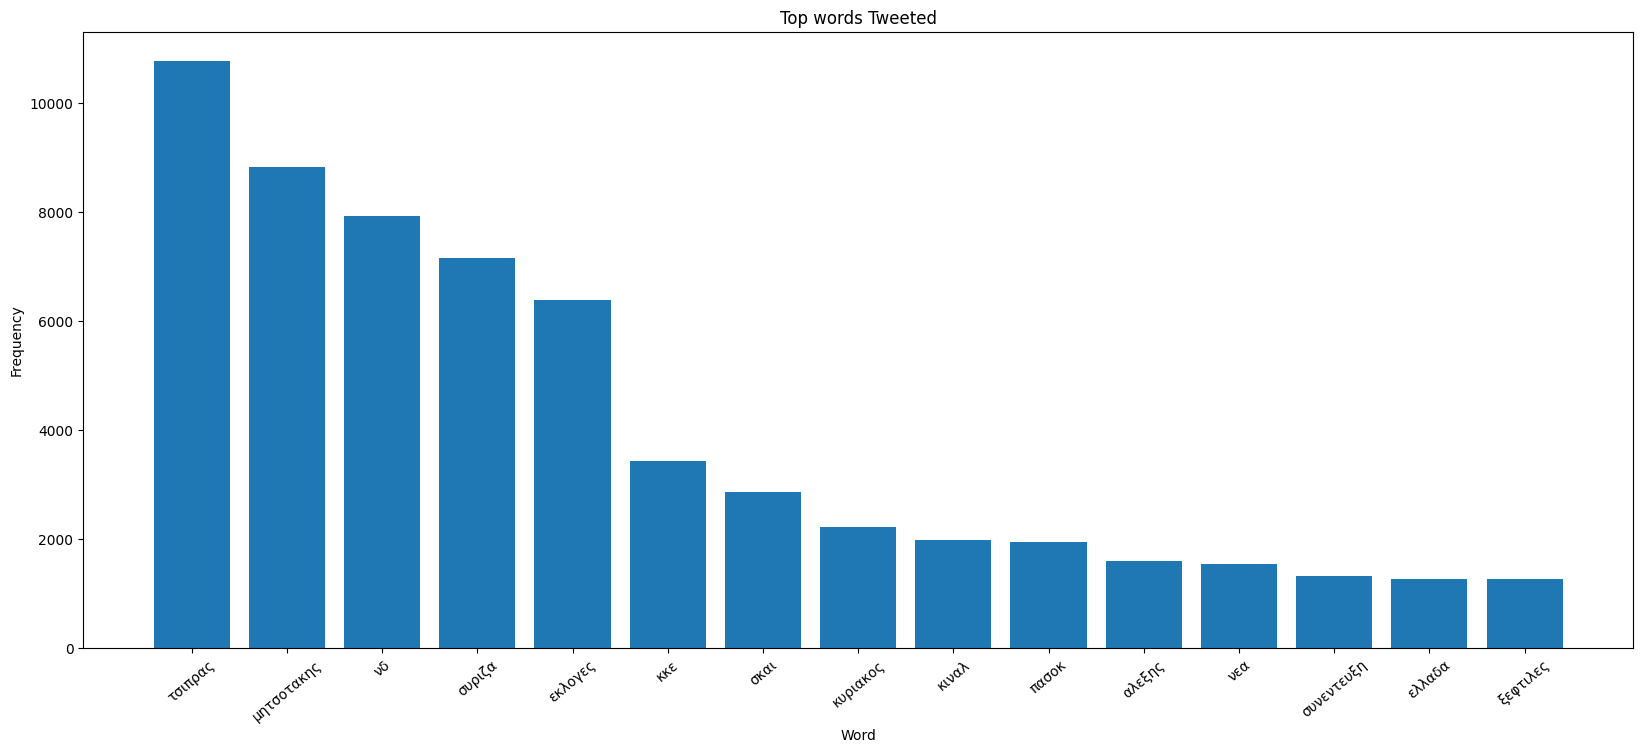

In [7]:
# ---- Bar Plots ----

plt.figure(figsize = (20, 8))

def find_top_words(column):
    count = Counter(word for words in column for word in words)      # Calculate word frequencies using Counter
    top_words = count.most_common(15)                                # and select the top 10 of them to show
    return pd.DataFrame(top_words, columns = ['Word', 'Frequency'])  # Create a DataFrame for plotting

# Top words used on Tweeter for the Greek Elections 
top_tweet_words = find_top_words(df_train['Tokens'])

plt.bar(top_tweet_words['Word'], top_tweet_words['Frequency'])
plt.xticks(rotation = 40)
plt.title('Top words Tweeted')
plt.xlabel('Word')
plt.ylabel('Frequency')

# Show all analysis #
plt.show()

Text(0.5, 1.0, 'WordCloud')

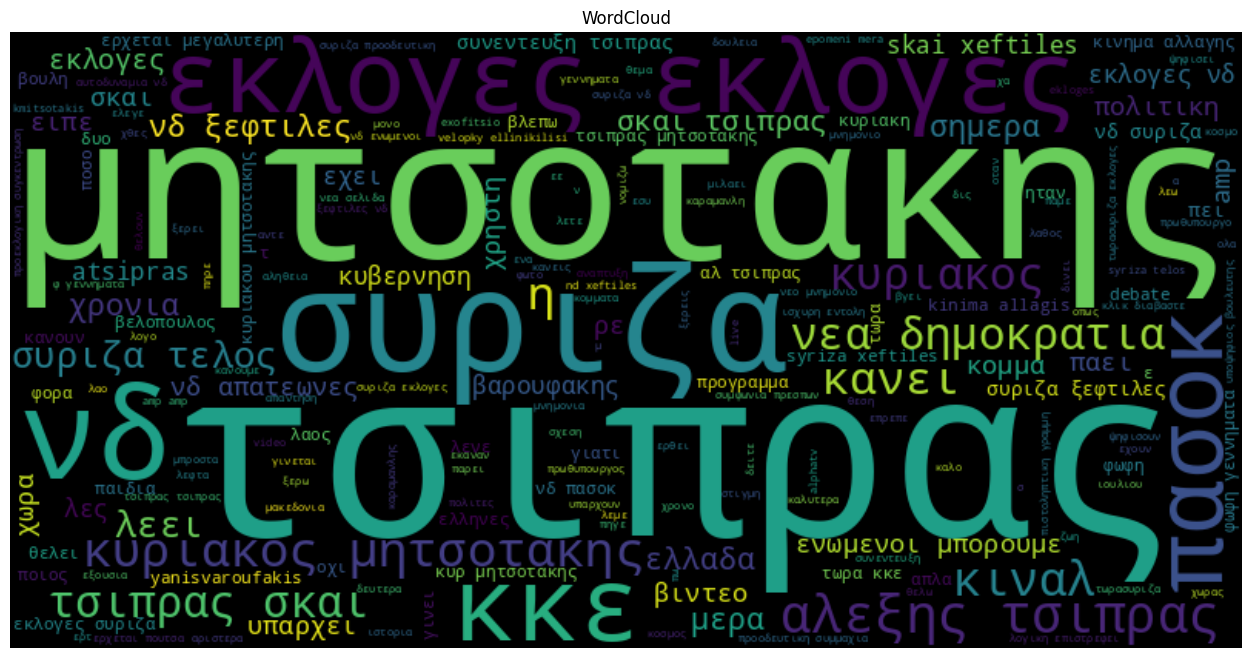

In [8]:
# ---- WordCloud for all dataset's text ----

plt.figure(figsize = (20, 8))

cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(df_train['Text']))

plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('WordCloud')

<Figure size 2000x500 with 0 Axes>

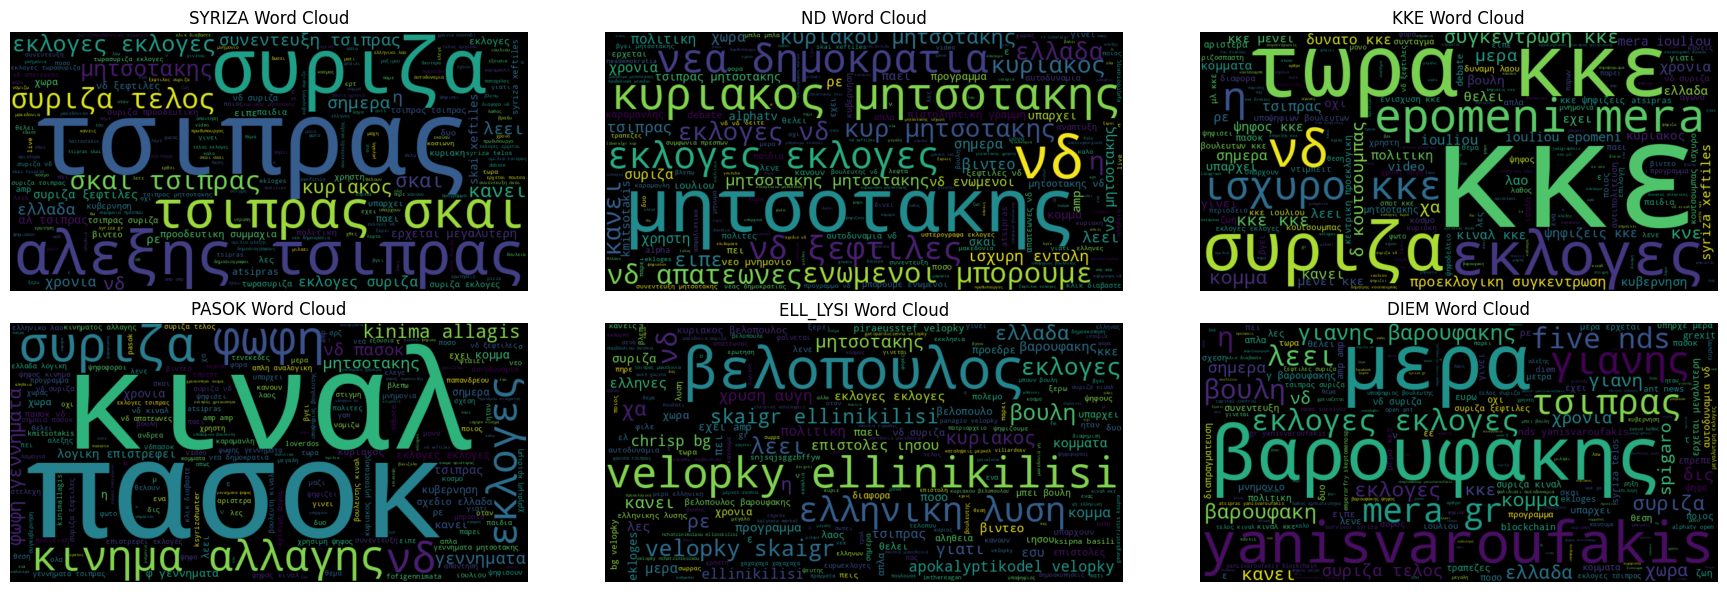

In [9]:
# ---- WordCloud for each Party ----

plt.figure(figsize = (20, 5))

parties = df_train['Party'].unique()

fig, axes = plt.subplots(nrows = (len(parties) // 3) + (len(parties) % 3 > 0), ncols = 3, figsize = (18, 6)) # Many word clouds so split for plotting

for i, party in enumerate(parties, start = 1):
    cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(df_train[df_train['Party'] == party]['Text']))
    
    if len(parties) > 3:    # In a dataset im not
        row = (i - 1) // 3  # sure how many parties there 
        col = (i - 1) % 3   # are maybe it will come in handy
        ax = axes[row, col]
    else:
        ax = axes[i - 1]
    
    ax.imshow(cloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set_title(f'{party} Word Cloud')

plt.tight_layout()
plt.show()

<Figure size 2000x500 with 0 Axes>

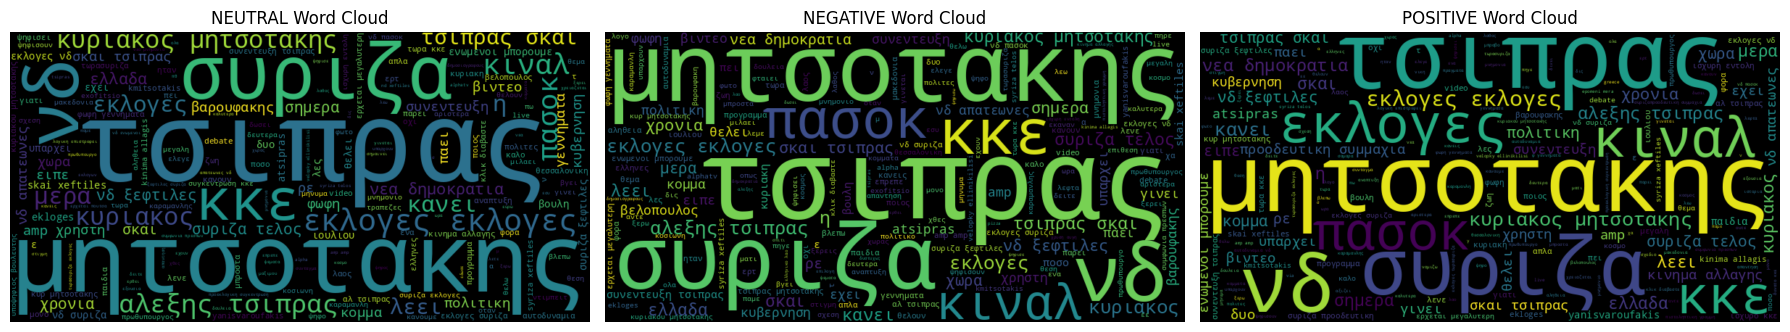

In [10]:
# ---- WordCloud for each Sentiment ----

plt.figure(figsize = (20, 5))

sentiments = df_train['Sentiment'].unique()

fig, axes = plt.subplots(nrows = (len(sentiments) // 3) + (len(sentiments) % 3 > 0), ncols = 3, figsize = (18, 6))

for i, sentiment in enumerate(sentiments, start = 1):
    cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(df_train[df_train['Sentiment'] == sentiment]['Text']))
    
    if len(sentiments) > 3: # In a dataset im not
        row = (i - 1) // 3  # sure how many sentiments there
        col = (i - 1) % 3   # are maybe it will come in handy
        ax = axes[row, col]
    else:
        ax = axes[i - 1]
    
    ax.imshow(cloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set_title(f'{sentiment} Word Cloud')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Top 3 Parties Word Cloud')

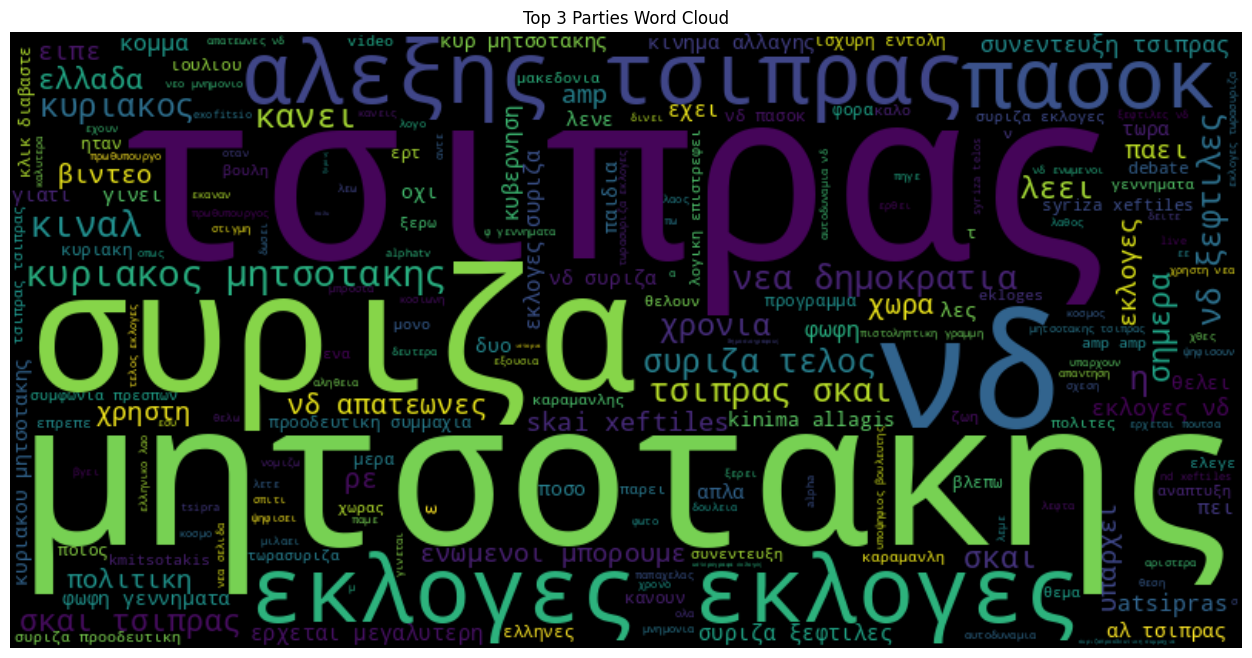

In [11]:
# ---- Word Cloud based on parties ----

plt.figure(figsize = (20, 8))

# WordCloud for the top 3 Political Parties
column = df_train[df_train['Party'].isin(['SYRIZA', 'ND', 'PASOK'])]['Text']
cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(column))

plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 3 Parties Word Cloud')

# Vectorization, Word Embeddings & Data partioning

In [12]:
# ---- Embeddings, Train / Valid (test) ----

def word_embeddings(column, model):
    embedding_vector = np.zeros((len(column), model.vector_size)) # Initialization of embeddings with zeros
    word_count = [len(sublist) for sublist in column]             # Count the words of every text

    for i, sentence in enumerate(column):
        embeddings = [model.wv[word] for word in sentence if word in model.wv] # .wv is vector that describes the word in numbers
        if word_count[i] > 0:
            embedding_vector[i] = sum(embeddings) / word_count[i]
            
    return embedding_vector

vector = Word2Vec(df_train['Tokens'], vector_size = 200, seed = 42, epochs = 20)
vector.train(df_train['Tokens'], total_examples = len(df_train['Tokens']), epochs = vector.epochs)

X_train = word_embeddings(df_train['Tokens'], vector)
Y_train = df_train['Sentiment_encoded']
        
X_valid = word_embeddings(df_valid['Tokens'], vector)
Y_valid = df_valid['Sentiment_encoded']

# Tensors

In [13]:
# ---- Saving to tensors ----

x_train = torch.tensor(X_train, dtype = torch.float)      
y_train = torch.tensor(Y_train.values, dtype = torch.long)
x_valid = torch.tensor(X_valid, dtype = torch.float)
y_valid = torch.tensor(Y_valid.values, dtype = torch.long)

# Neural Network

In [14]:
# ---- Neural Network with 3 hidden layers ----

class Neural_Network(nn.Module):
    def __init__(self, input_size, hidden_layer1, hidden_layer2, hidden_layer3, output_size):
        super(Neural_Network, self).__init__()
        
        torch.manual_seed(42)
        self.activation = nn.ReLU()                          # Other Activation functions | PReLU, ReLU, ELU, Sigmoid, tanh
        self.layer1 = nn.Linear(input_size, hidden_layer1)       
        self.layer2 = nn.Linear(hidden_layer1, hidden_layer2)   
        self.layer3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.output = nn.Linear(hidden_layer3, output_size)
        
    def forward(self, x):
        layer1 = self.activation(self.layer1(x))
        layer2 = self.activation(self.layer2(layer1))
        layer3 = self.activation(self.layer3(layer2))
        return self.output(layer3)

In [15]:
# ---- Setting up criterion, optimizer, data ----

model = Neural_Network(x_train.shape[1], 128, 64, 32, 3)

criterion = nn.CrossEntropyLoss()                            # Initialize criterion
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5) # Initialize optimizer

dataset = TensorDataset(x_train, y_train)                           # Class to represent the data as list of tensors
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)   # Initialize dataloader

# Neural Network Training

In [16]:
# ---- Using forward & back propagation for training ----

for epoch in range(10):
    losses = []
    model.train()
    for x, y in dataloader:
        logits = model(x)           # Perform forward propagation
        
        loss = criterion(logits, y) # Calculating the loss using criterion function
        losses.append(loss.item())
        
        optimizer.zero_grad()       # Delete previously stored gradients
        loss.backward()             # Perform back propagation starting from the loss calculated in this epoch
        optimizer.step()            # Update model's weights based on the gradients calculated during backprop
        
    print(f'Epoch {epoch}: Loss = {sum(losses) / len(dataloader):.5f}')

Epoch 0: Loss = 1.10255
Epoch 1: Loss = 1.10039
Epoch 2: Loss = 1.09860
Epoch 3: Loss = 1.09685
Epoch 4: Loss = 1.09501
Epoch 5: Loss = 1.09312
Epoch 6: Loss = 1.09125
Epoch 7: Loss = 1.08955
Epoch 8: Loss = 1.08809
Epoch 9: Loss = 1.08688


# Validation

In [17]:
model.eval()
with torch.no_grad():
    logits_valid = model(x_valid)
    probabilities = nn.functional.softmax(logits_valid, dim = 1)
    predictions = torch.argmax(probabilities, dim = 1)

accuracy = accuracy_score(y_valid.numpy(), predictions.numpy())
f1 = f1_score(y_valid.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)                 
recall = recall_score(y_valid.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)        
precision = precision_score(y_valid.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)
                          
table = [['Method', 'Accuracy', 'F1-Score', 'Recall', 'Precision'],
         ['Predict', accuracy, f1, recall, precision]]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════╤════════════╤════════════╤══════════╤═════════════╕
│ Method   │   Accuracy │   F1-Score │   Recall │   Precision │
╞══════════╪════════════╪════════════╪══════════╪═════════════╡
│ Predict  │   0.394304 │   0.380349 │ 0.394304 │     0.40077 │
╘══════════╧════════════╧════════════╧══════════╧═════════════╛


# Hyper-parameters

In [18]:
# ---- Using Optuna ----

def objective(trial):
    H1 = trial.suggest_int('H1', 64, 128)
    H2 = trial.suggest_int('H2', 32, 64)
    H3 = trial.suggest_int('H3', 8, 32)
    model = Neural_Network(x_train.shape[1], H1, H2, H3, 3)
    
    criterion = nn.CrossEntropyLoss()
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log = True)
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'AdamW'])
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    elif optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    elif optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

    dataset = TensorDataset(x_train, y_train)
    dataloader = DataLoader(dataset, batch_size = 64, shuffle = True) 
    
    for epoch in range(10):
        model.train()
        for x, y in dataloader:
            logits = model(x)           # Perform forward propagation

            loss = criterion(logits, y) # Calculating the loss using criterion function
            
            optimizer.zero_grad()       # Delete previously stored gradients
            loss.backward()             # Perform back propagation starting from the loss calculated in this epoch
            optimizer.step()            # Update model's weights based on the gradients calculated during backprop
                    
    model.eval()
    with torch.no_grad():
        logits_valid = model(x_valid)
        probabilities = nn.functional.softmax(logits_valid, dim = 1)
        predictions = torch.argmax(probabilities, dim = 1)

    accuracy = accuracy_score(y_valid.numpy(), predictions.numpy())
        
    return accuracy

study = optuna.create_study(direction = 'maximize', study_name = 'Christos study')
study.optimize(objective, n_trials = 100)
best_parameters = study.best_params

best_H1 = best_parameters['H1']
best_H2 = best_parameters['H2']
best_H3 = best_parameters['H3']
best_lr = best_parameters['learning_rate']
best_optimizer = best_parameters['optimizer']

print('Best hyperparameters: ', best_parameters)

[I 2023-12-24 22:59:23,664] A new study created in memory with name: Christos study
[I 2023-12-24 22:59:36,646] Trial 0 finished with value: 0.38188073394495414 and parameters: {'H1': 99, 'H2': 33, 'H3': 21, 'learning_rate': 0.0005328153930334868, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.38188073394495414.
[I 2023-12-24 22:59:49,045] Trial 1 finished with value: 0.40519877675840976 and parameters: {'H1': 72, 'H2': 51, 'H3': 11, 'learning_rate': 9.208361767509291e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.40519877675840976.
[I 2023-12-24 23:00:01,452] Trial 2 finished with value: 0.40156727828746175 and parameters: {'H1': 112, 'H2': 44, 'H3': 16, 'learning_rate': 8.523584744480383e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.40519877675840976.
[I 2023-12-24 23:00:14,900] Trial 3 finished with value: 0.4004204892966361 and parameters: {'H1': 101, 'H2': 64, 'H3': 8, 'learning_rate': 0.00021099607038734038, 'optimizer': 'Adam'}. Best is trial 1 with val

Best hyperparameters:  {'H1': 69, 'H2': 36, 'H3': 28, 'learning_rate': 0.00016327622708688433, 'optimizer': 'Adam'}


# Neural Network using Hyper-Parameters

In [19]:
# ---- Setting up criterion, optimizer, data ----

model = Neural_Network(x_train.shape[1], best_H1, best_H2, best_H3, 3)

criterion = nn.CrossEntropyLoss()

if best_optimizer == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr = best_lr)
elif best_optimizer == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = best_lr)
elif best_optimizer == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = best_lr)

dataset = TensorDataset(x_train, y_train)                           # Class to represent the data as list of tensors
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)   # Initialize dataloader

# Training using Hyper-Parameters

In [20]:
for epoch in range(10):
    losses = []
    model.train()
    for x, y in dataloader:
        logits = model(x)           # Perform forward propagation
        
        loss = criterion(logits, y) # Calculating the loss using criterion function
        losses.append(loss.item())
        
        optimizer.zero_grad()       # Delete previously stored gradients
        loss.backward()             # Perform back propagation starting from the loss calculated in this epoch
        optimizer.step()            # Update model's weights based on the gradients calculated during backprop
        
    print(f'Epoch {epoch}: Loss = {sum(losses) / len(dataloader):.5f}')

Epoch 0: Loss = 1.09340
Epoch 1: Loss = 1.08002
Epoch 2: Loss = 1.07419
Epoch 3: Loss = 1.07050
Epoch 4: Loss = 1.06772
Epoch 5: Loss = 1.06523
Epoch 6: Loss = 1.06317
Epoch 7: Loss = 1.06060
Epoch 8: Loss = 1.05829
Epoch 9: Loss = 1.05585


# Validation with Hyper-Parameters

In [21]:
model.eval()
with torch.no_grad():
    logits_valid = model(x_valid)
    probabilities = nn.functional.softmax(logits_valid, dim = 1)
    predictions = torch.argmax(probabilities, dim = 1)

accuracy = accuracy_score(y_valid.numpy(), predictions.numpy())
f1 = f1_score(y_valid.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)                 
recall = recall_score(y_valid.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)        
precision = precision_score(y_valid.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)
                          
table = [['Method', 'Accuracy', 'F1-Score', 'Recall', 'Precision'],
         ['Predict', accuracy, f1, recall, precision]]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════╤════════════╤════════════╤══════════╤═════════════╕
│ Method   │   Accuracy │   F1-Score │   Recall │   Precision │
╞══════════╪════════════╪════════════╪══════════╪═════════════╡
│ Predict  │   0.407301 │   0.389458 │ 0.407301 │    0.421659 │
╘══════════╧════════════╧════════════╧══════════╧═════════════╛


# Learning Curve, ROC, Confusion Matrix

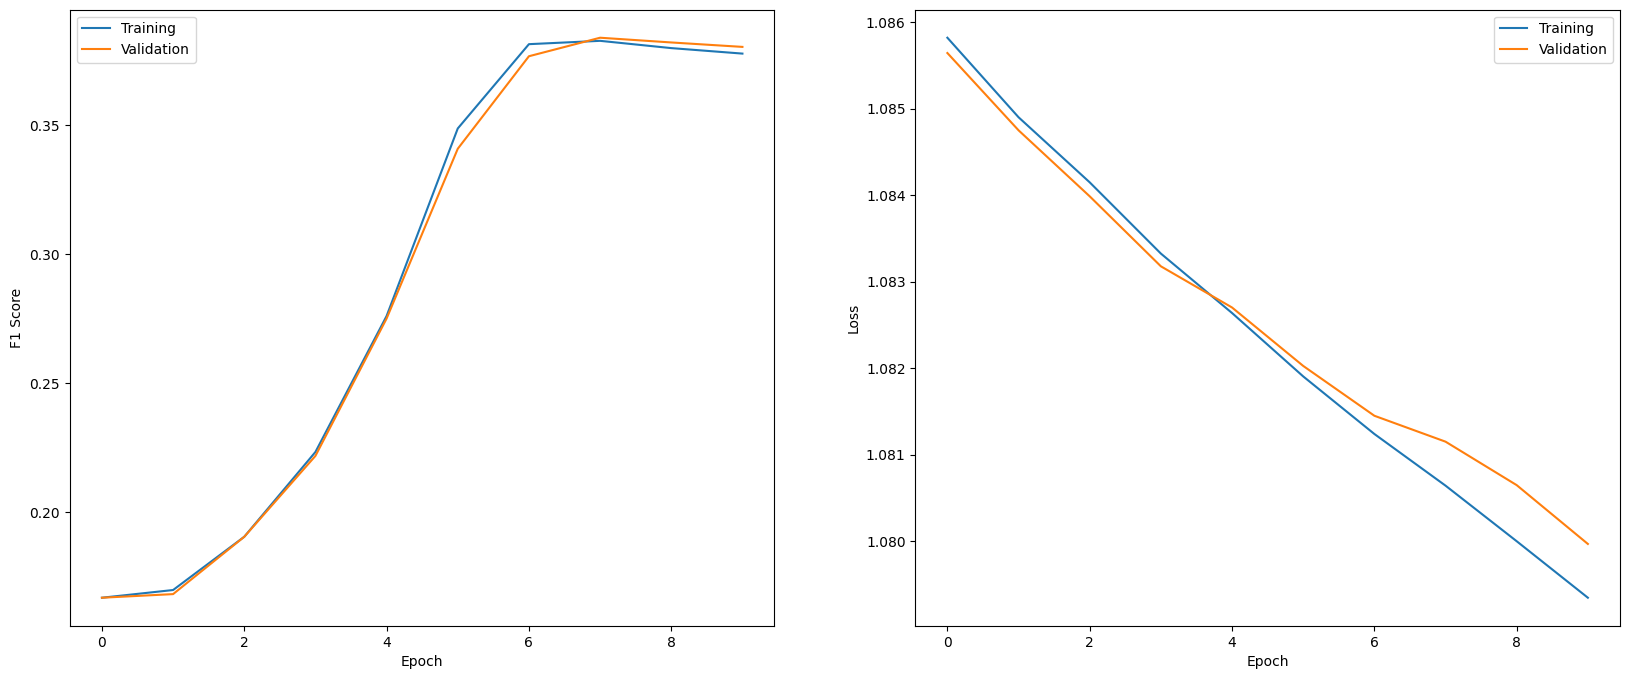

In [22]:
score_train = []
score_valid = []
losses_train = []
losses_valid = []

for i in range(2):
    model = Neural_Network(x_train.shape[1], 128, 64, 32, 3)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)

    dataset_train = TensorDataset(x_train, y_train)                               # Class to represent the data as list of tensors
    dataloader_train = DataLoader(dataset_train, batch_size = 64, shuffle = True) # Initialize dataloader

    dataset_valid = TensorDataset(x_valid, y_valid)                               # Class to represent the data as list of tensors
    dataloader_valid = DataLoader(dataset_valid, batch_size = 64, shuffle = True) # Initialize dataloader

    if i == 0:
        for epoch in range(10):
            model.train()
            for x, y in dataloader_train:
                logits = model(x)           # Perform forward propagation

                loss = criterion(logits, y) # Calculating the loss using criterion function

                optimizer.zero_grad()       # Delete previously stored gradients
                loss.backward()             # Perform back propagation starting from the loss calculated in this epoch
                optimizer.step()            # Update model's weights based on the gradients calculated during backprop

            model.eval()
            with torch.no_grad():
                logits_train = model(x_train)
                probabilities = nn.functional.softmax(logits_train, dim = 1)
                predictions = torch.argmax(probabilities, dim = 1)

            f1_train = f1_score(y_train.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)
            score_train.append(f1_train)

            model.eval()
            with torch.no_grad():
                logits_valid = model(x_valid)
                probabilities = nn.functional.softmax(logits_valid, dim = 1)
                predictions = torch.argmax(probabilities, dim = 1)

            f1_valid = f1_score(y_valid.numpy(), predictions.numpy(), average = 'macro', zero_division = 1)
            score_valid.append(f1_valid)
        
    else:
        for epoch in range(10):
            losses = []
            model.train()
            for x, y in dataloader_train:
                logits = model(x)           # Perform forward propagation

                loss = criterion(logits, y) # Calculating the loss using criterion function
                losses.append(loss.item())

                optimizer.zero_grad()       # Delete previously stored gradients
                loss.backward()             # Perform back propagation starting from the loss calculated in this epoch
                optimizer.step()            # Update model's weights based on the gradients calculated during backprop

            loss = sum(losses) / len(dataloader_train)
            losses_train.append(loss)

            losses = []
            model.eval()
            with torch.no_grad():
                for x, y in dataloader_valid:
                    logits = model(x)           # Perform forward propagation

                    loss = criterion(logits, y) # Calculating the loss using criterion function
                    losses.append(loss.item())

                loss = sum(losses) / len(dataloader_valid)
                losses_valid.append(loss)

plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.plot(score_train, label = 'Training')
plt.plot(score_valid, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses_train, label = 'Training')
plt.plot(losses_valid, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Total AUC:  0.56


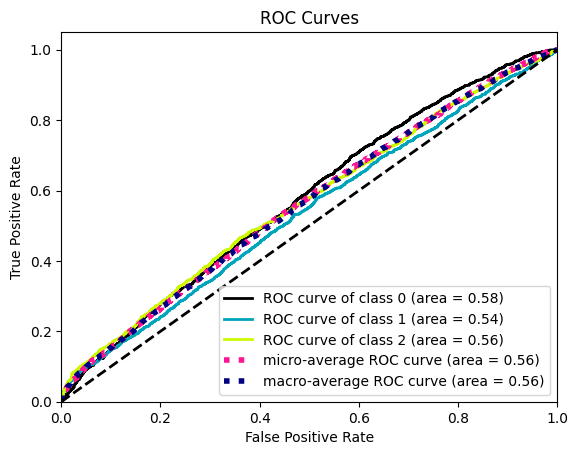

In [23]:
# ---- ROC Curve / AUC Score ----

auc = np.round(roc_auc_score(y_valid.numpy(), probabilities.detach().numpy(), multi_class = 'ovo'), 3)
print('Total AUC: ', auc)

scikitplot.metrics.plot_roc(y_valid.numpy(), probabilities.detach().numpy())
plt.show()

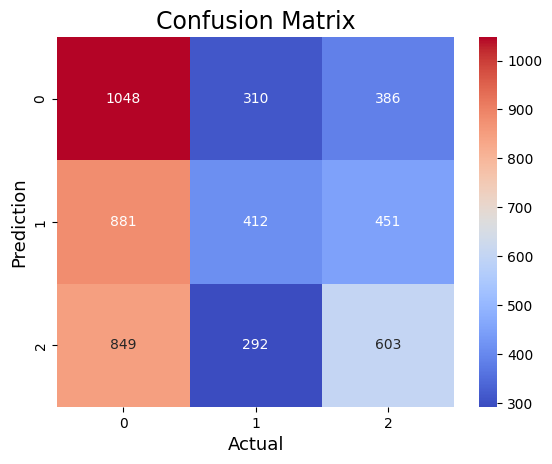

In [24]:
# ---- Confusion Matrix ----

confusion_martix = metrics.confusion_matrix(y_valid.numpy(), predictions.numpy())

sns.heatmap(confusion_martix, annot = True, fmt = 'd', cmap = 'coolwarm')
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Actual', fontsize = 13)
plt.title('Confusion Matrix', fontsize = 17)
plt.show()

# Final Predictions

In [25]:
def replace_sentiment(column):
    map_sentiments = {
        0: 'NEGATIVE',
        1: 'NEUTRAL',
        2: 'POSITIVE',
    }
    return list(map(map_sentiments.get, column))

X_test = word_embeddings(df_test['Tokens'], vector)
x_test = torch.tensor(X_test, dtype = torch.float)

model.eval()
with torch.no_grad():
    logits_test = model(x_test)
    probabilities = nn.functional.softmax(logits_test, dim = 1)
    predictions = torch.argmax(probabilities, dim = 1)

df_test['Sentiment'] = predictions
df_test['Sentiment'] = replace_sentiment(df_test['Sentiment'])

In [26]:
df_predictions = df_test[['New_ID', 'Sentiment']]                                            # The dataset to output needs only
df_predictions = df_predictions.rename(columns = {'New_ID': 'Id', 'Sentiment': 'Predicted'}) # the 2 columns of sentiments and ids
df_predictions.to_csv('submission.csv', index = False)